In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

In [11]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 5
macro_configs = config_generator(task_seed=list(range(55, 65)),
                                 N_train=[500000, 1000000, 3000000],
                                 T_truncation=[5, 10, 15, 20])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = False
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [ ]:
### --- Generate Task --- ###
np.random.seed(params['task_seed'])
FPs, T_dict = generate_ergodic_markov_task()
task = Fixed_Point_Transition_Task(FPs, T_dict, p_transition=0.15, tau_decay=0.05)

In [ ]:
### --- Train on task --- ###
np.random.seed(i_seed)

N_train = params['N_train']
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 64
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = Efficient_BPTT(rnn, T_truncation=params['T_truncation'], L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=0.0003, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

In [ ]:
test_sim = Simulation(rnn)
test_sim.run(data, mode='test', monitors=['rnn.loss_'], verbose=False)
processed_data = np.mean(test_sim.mons['rnn.loss_'])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'task': task,
          'config': params, 'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [12]:
###Truncate file above
file_name = 'abstract_task_configs'
job_name = 'abstract_decay_array_3'
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py ../cluster_main_scripts/{}.py'.format(file_name, job_name))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook abstract_task_configs.ipynb to script
[NbConvertApp] Writing 4298 bytes to abstract_task_configs.py
awk: 1: unexpected character '.'


In [13]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name))
job_id_1 = submit_job('../job_scripts/{}.s'.format(job_name), n_jobs)

rm: cannot remove '/scratch/oem214/learning-dynamics/results/abstract_decay_array_3/result_*': No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/main.py
vanilla-rtrl/main2.py
vanilla-rtrl/main_test.py
vanilla-rtrl/test.py
vanilla-rtrl/test_2.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/.ipynb_checkpoints/test_interface-checkpoint.ipynb
vanilla-rtrl/__pycache__/
vanilla-rtrl/__pycache__/analysis.cpython-36.pyc
vanilla-rtrl/__pycache__/analysis_funcs.cpython-36.pyc

vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/__pycache__/
vanilla-rtrl/learning_algorithms/__pycache__/DNI.cpython-37.pyc
vanilla-rtrl/learning_algorithms/__pycache__/DNI.cpython-38.pyc
vanilla-rtrl/learning_algorithms/__pycache__/Efficient_BPTT.cpython-37.pyc
vanilla-rtrl/learning_algorithms/__pycache__/Efficient_BPTT.cpython-38.pyc
vanilla-rtrl/learning_algorithms/__pycache__/Future_BPTT.cpython-37.pyc
vanilla-rtrl/learning_algorithms/__pycache__/Future_BPTT.cpython-38.pyc
vanilla-rtrl/learning_algorithms/__pycache__/KF_RTRL.cpython-37.pyc
vanilla-rtrl/learning_algorithms/__pycache__/KF_RTRL.cpython-38.pyc
vanilla-rtrl/learning_algorithms/__pycache__/KeRNL.cpython-37.pyc
vanilla-rtrl/learning_algorithms/__pycache__/KeRNL.cpython-38.pyc
vanilla-rt

In [21]:
###Get job status
get_ipython().system('squeue -u oem214')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8873281        cm  jupyter   oem214  R    3:46:23      1 cm36


In [22]:
job_name = 'abstract_decay_array_3'
configs_array, results_array, key_order, sim_dict = unpack_processed_data('../job_scripts/{}.s'.format(job_name))

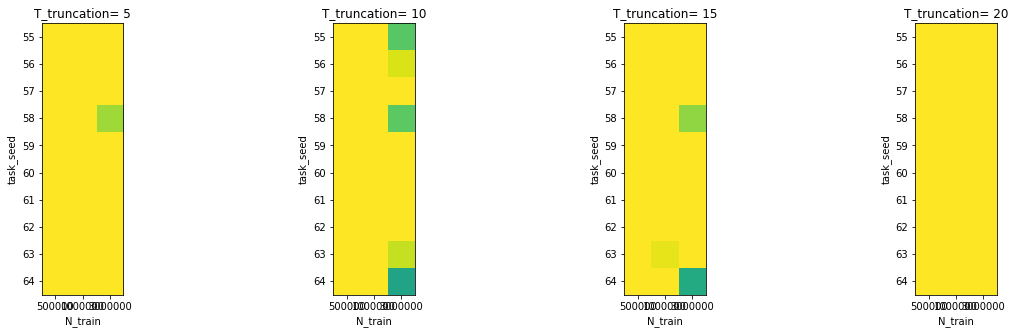

In [25]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order, tick_rounding=5,
                                            vmin=0, vmax=0.003)

In [ ]:
results_array.shape

In [ ]:
fig = plot_2d_array_of_config_results(configs_array, results_array, key_order, log_scale=False)

In [ ]:
plt.hist(results_array.flatten())

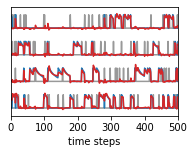

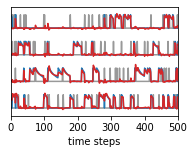

In [29]:
sim = sim_dict['64_3000000_15_0']
np.random.seed(64)
FPs, T_dict = generate_ergodic_markov_task()
task = Fixed_Point_Transition_Task(FPs, T_dict, p_transition=0.15, tau_decay=0.05)
data = task.gen_data(100, 5000)
plot_output_from_checkpoint(sim.checkpoints[max(sim.checkpoints.keys())], data)